# 1. Install Dependencies and Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
import tensorflow as tf


# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr

In [17]:
data_dir = '/content/drive/MyDrive/ImageClassification/data'

In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
import os

In [18]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/drive/MyDrive/ImageClassification/data/happy/HappyPeopleBanner.png
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/1-2.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/7-Habits-of-Happy-People-image.jpeg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/1902587.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/960x0.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/ADea4I4CgV4-hlxUOAdFjyNYonWRHO6Pu4jWXKk9BJScXws64-c-mo.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/A_Sep20_14_1189155141.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/HAPPY-PEOPLE-CLUB-LOGO.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/60632274._UY200_.jpg
Issue with image /content/drive/MyDrive/ImageClassification/data/happy/Happy_People_Happy_Man.jpg
Issue with image /content/drive/MyDrive/Im

# 3. Load Data

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf

In [24]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
batch = data.as_numpy_iterator().next()

Found 305 files belonging to 2 classes.


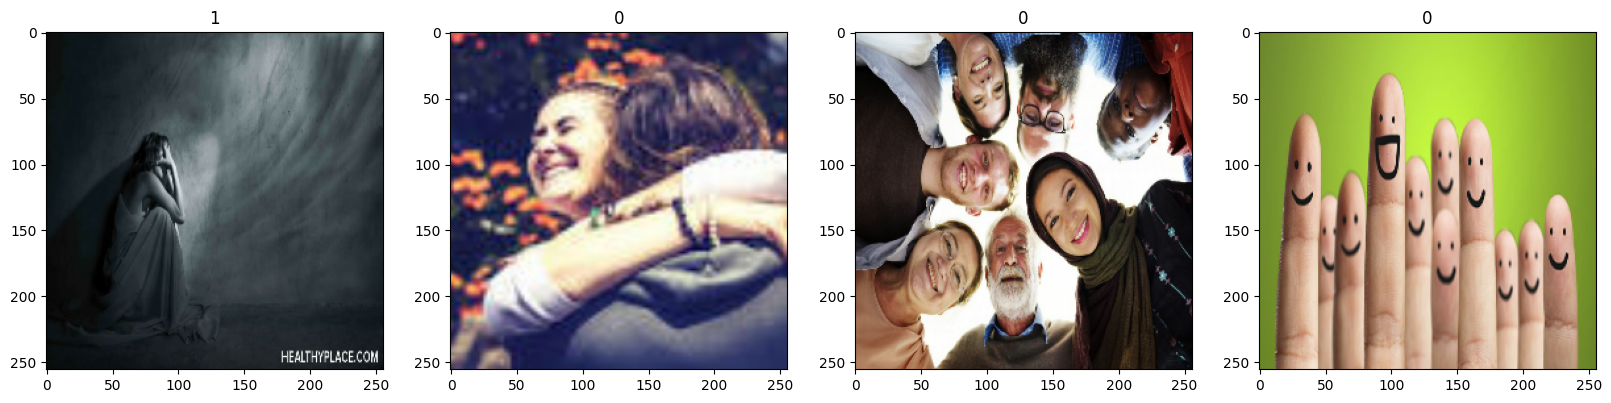

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [26]:
#print("Vraies étiquettes :", batch[1][:4].numpy())  # Vérifiez si les labels sont bien 0 (Happy) et 1 (Sad)
print("Vraies étiquettes :", batch[1][:4])


Vraies étiquettes : [1 0 0 0]


# 4. Scale Data

In [27]:
data = data.map(lambda x,y: (x/255, y))

In [29]:
data.as_numpy_iterator().next()

(array([[[[0.26666668, 0.26666668, 0.26666668],
          [0.26666668, 0.26666668, 0.26666668],
          [0.26666668, 0.26666668, 0.26666668],
          ...,
          [0.00579044, 0.00579044, 0.00579044],
          [0.00425858, 0.00425858, 0.00425858],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.2673407 , 0.2673407 , 0.2673407 ],
          [0.2673407 , 0.2673407 , 0.2673407 ],
          [0.2673407 , 0.2673407 , 0.2673407 ],
          ...,
          [0.00579044, 0.00579044, 0.00579044],
          [0.00425858, 0.00425858, 0.00425858],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.2704044 , 0.2704044 , 0.2704044 ],
          [0.2704044 , 0.2704044 , 0.2704044 ],
          [0.2704044 , 0.2704044 , 0.2704044 ],
          ...,
          [0.00579044, 0.00579044, 0.00579044],
          [0.00425858, 0.00425858, 0.00425858],
          [0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.09816176, 0.09816176, 0.09816176],
          [0.10356

# 5. Split Data

In [30]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [31]:
train_size

7

In [32]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [36]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
#!pip install tensorflow


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [35]:
model = Sequential()

In [39]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # 1 --> Indique un pas de convolution (stride = 1).
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [42]:
logdir='logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5470 - loss: 1.1464 - val_accuracy: 0.4688 - val_loss: 0.6728
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5363 - loss: 0.6527 - val_accuracy: 0.6406 - val_loss: 0.6029
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6498 - loss: 0.5719 - val_accuracy: 0.8594 - val_loss: 0.4946
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7935 - loss: 0.4922 - val_accuracy: 0.8438 - val_loss: 0.4096
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8158 - loss: 0.4443 - val_accuracy: 0.8906 - val_loss: 0.3388
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8709 - loss: 0.3854 - val_accuracy: 0.9531 - val_loss: 0.2744
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8829 - loss: 0.3205 - val_accuracy: 0.9219 - val_loss: 0.2783
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9617 - loss: 0.1783 - val_accuracy: 0.9531 - val_loss: 0.1772
Epoch 9/

# 8. Plot Performance

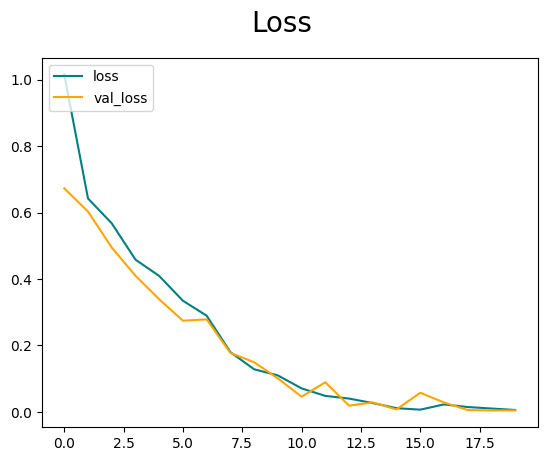

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Text(0.5, 0.98, 'Accuracy')

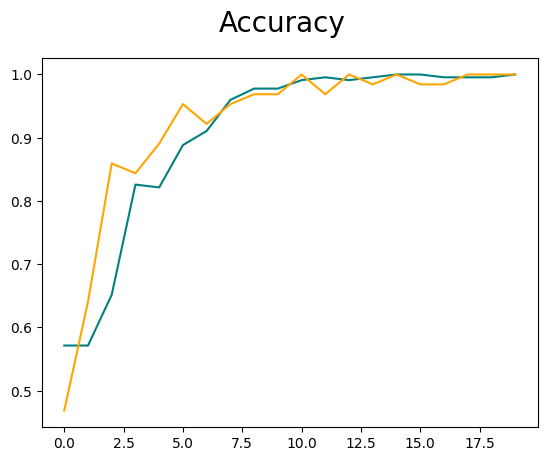

In [48]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = ____________
re = __________
acc = ______________

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())


# 10. Test

In [ ]:
import cv2

In [ ]:

img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/happy.jpg')
#plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionner l'image avec TensorFlow
_________________________________

# Afficher correctement l'image
________________________________  # Utiliser "uint8" pour éviter des erreurs d'affichage
plt.axis("off")  # Supprimer les axes pour un meilleur rendu
plt.show()

In [ ]:
# resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype("uint8"))
# plt.show()

In [ ]:
resize.shape

In [ ]:
np.expand_dims(resize,0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
#yhat = model.predict(batch[0][:4])  # Prédictions sur 4 images
#print("Prédictions brutes :", yhat.flatten())  # Afficher les scores entre 0 et 1


In [ ]:
# for idx, score in enumerate(yhat.flatten()):
#     predicted_class = "Sad" if score > 0.5 else "Happy"
#     print(f"Image {idx+1} : Score={score:.4f} → Prédiction : {predicted_class}")


In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Sauvegarde du modèle dans Google Drive
model.save("/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/imageclassifier.keras")


In [ ]:
new_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/imageclassifier.keras')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))